# The Embedding Notebook 6
## John E. Inglesfield
This is the sixth embedding notebook, providing short computer programs to illustrate the embedding method, and to accompany my book *The Embedding Method for Electronic Structure* (ebook ISBN 978-0-7503-1042-0, print ISBN 978-0-7503-1043-7), published in the *Expanding Physics* ebook program by [IOP Publishing](http://iopscience.iop.org/books/iop-expanding-physics). As with the earlier notebooks, this can be used independently of the book, but the references are to chapters, figures, and equations. In this notebook, describing electromagnetic embedding for solving Maxwell's equations, Gaussian units are used, with wave-vector and frequency expressed in dimensionless form so that the reduced speed of light $\tilde{c}=1$.

This notebook uses the `matplotlib`, `scipy`, and `numpy` modules, as well as the `maxwell.py` module in the repository, which itself uses `numpy`, `scipy`, `math`, and `cmath`. Here I use the Python class structure with the `maxwell` module containing the `Waveguide` and `Cylinder` classes; this simplifies the structure of the code. The modules we need are loaded in the following cell.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, AutoMinorLocator
from scipy.optimize import bisect
import maxwell
%matplotlib inline

# Chapter 9 Embedding in electromagnetism
Embedding can be used to solve Maxwell's equations in two ways. Firstly, as in solving Schrödinger's equation, we often need to solve Maxwell's equations with an extended (usually vacuum) substrate – this can be eliminated using an embedding potential; secondly, there are invariably dielectric objects with a sharp boundary, which give rise to convergence problems using conventional plane-wave expansions – these can be replaced using embedding, thereby improving convergence. A fundamental difference between Maxwell and Schrödinger is that the electric and magnetic fields are *vector* fields, unlike the scalar wave-function. This means the embedding potential becomes the embedding tensor, which relates the surface-parallel components of the magnetic and electric fields on the boundary of region II, as discussed in chapter 9 of the book and in the original paper by [Inglesfield](http://iopscience.iop.org/article/10.1088/0305-4470/31/42/009?pageTitle=IOPscience). Other applications of electromagnetic embedding are given in [Pitarke *et al*](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.75.165415) and [Giannakis *et al*](https://www.osapublishing.org/josab/abstract.cfm?uri=josab-30-6-1755).

## The dielectric waveguide ##
The first type of problem we solve in this notebook is an electromagnetic waveguide, in which light propagates between semi-infinite dielectrics. The geometry is given in the figure below,  ![Dielectric waveguide](em_slab.png)  
with the vacuum region I between semi-infinite dielectrics (region II, shaded green) at $x=\pm d/2$. We consider TM modes propagating in the $y$-direction with wave-vector $k_y$, with an electric field in the $xy$-plane and 
magnetic field in the $z$-direction perpendicular to the diagram. With the dielectric constant $\epsilon<1$, total internal reflection can occur at the vacuum-dielectric boundaries, giving rise to states which are localised in region I. We can use embedding to study these localised states, replacing the dielectrics by embedding tensors and expanding the electric field in region I in basis functions. The results can be tested against the exact frequencies, found by elementary matching of fields across the dielectric boundaries.  


###  Exact solution of bound states in waveguide ###
The exact frequencies of symmetric localised states satisfy the equation
$$\tan\frac{k_x d}{2}=\frac{\gamma}{\epsilon k_x},$$
where $k_x=\sqrt{\frac{\omega^2}{c^2}-k_y^2}$, the wave-vector in the $x$-direction, and $\gamma=\sqrt{k_y^2-\epsilon\frac{\omega^2}{c^2}}$, the decay constant in the dielectric.  
Likewise the antisymmetric states satisfy
$$-\cot\frac{k_x d}{2}=\frac{\gamma}{\epsilon k_x}.$$
It is convenient to introduce the dimensionless reduced wave-vector and frequency given by
$$\tilde{k}_y=\frac{k_y d}{2\pi},\;\;\tilde{\omega}=\frac{\omega d}{2\pi c}.$$
We also set $d=2\pi$ (built in to the `Waveguide` class) giving $\tilde{k}_y=k_y,\; \tilde{\omega}=\omega$, and we can omit the tildes in the rest of the notebook.  
To solve these matching equations we first obtain approximate values graphically, plotting the left- and right-hand side of these equations as a function of $\omega$, and then refining these by bisection. 

We start by initiating the `Waveguide` class, with input $\epsilon$ and $k_y$. Typical values, which are used in section 9.1.2 of the book, are $\epsilon=0.5$ and $k_y=1$. We then calculate and plot the functions.

In [2]:
epsilon = 0.5 # dielectric constant (must be < 1)
ky = 1.0      # wave-vector in direction of propagation
wg = maxwell.Waveguide(epsilon, ky)  # wg is the instance of the Waveguide class

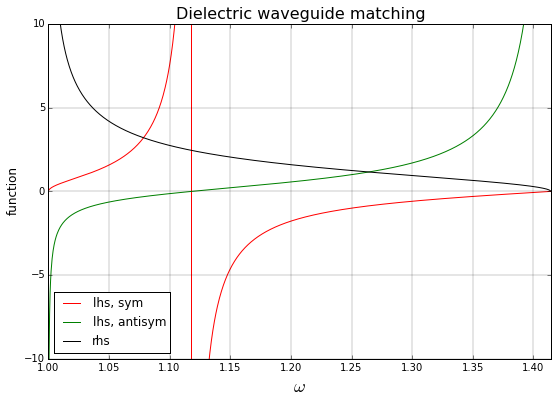

In [3]:
wmin, wmax = ky, ky/np.sqrt(epsilon)
wlist = np.linspace(wmin+0.0001, wmax-0.0001, 1000)
functions = np.array([wg.match(w)[0:3] for w in wlist])
colour = ['red', 'green', 'black']
key = ['lhs, sym', 'lhs, antisym', 'rhs']
fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(1, 1, 1)
ax.axis([wmin, wmax, -10.0, +10.0])
ax.grid(linestyle='-', linewidth=0.2)
ax.set_xlabel('$\omega$', fontsize=18)
ax.set_ylabel('function', fontsize=12)
ax.set_title('Dielectric waveguide matching', fontsize=16)
for n in range(3):
    ax.plot(wlist, functions[:, n], color=colour[n], label=key[n])
ax.legend(fontsize=12, loc='best')

The red curve plots the left-hand side of the equation for the symmetric localised states, and where this intersects the black curve, showing the right-hand side, gives the frequency (or frequencies) of these states; an intersection with a vertical red  line should be ignored, as this runs between $\pm\infty$ when `tan` blows up. Similarly the intersection of the green and black curves gives the frequencies of the antisymmeytric localised states, again ignoring an intersection with a vertical green line.  
To refine the frequencies of the localised states we use bisection, inputting whether symmetric (`n = 0`) or antisymmetric (`n = 1`), and frequencies `w1` and `w2` which span the required root.

In [4]:
n = 1   # input n = 0 for symmetric state, n = 1 for antisymmetric
w1, w2 = 1.2, 1.3  # input frequencies spanning the root
w = bisect(lambda w: wg.match(w)[n]-wg.match(w)[2], w1, w2)
type = ['symmetric', 'antisymmetric']
print '%s %s %s %11.8f' % ('exact energy of', type[n], 'state =' ,w)

exact energy of antisymmetric state =  1.26418745


### Variational embedding with transverse basis functions ###
We now find the localised states of the waveguide by embedding, solving Maxwell's equations (or the Helmholtz equation) in region I with the embedding tensor given by (9.26) and (9.27) replacing the dielectrics. As we are looking for transverse solutions of Maxwell's equations, in this section we try expanding the electric field in region I in terms of transverse waves. These are given by (equation (9.28))
$$ \textbf{F}^t_m(x,y)=(k_y\hat{\textbf{x}}-g_m\hat{\textbf{y}})\exp\text{i}(g_m x + k_y y),\;\;g_m=\frac{2m\pi}{D}.$$
Here $\hat{\textbf{x}}$ and $\hat{\textbf{y}}$ are unit vectors in the $x$ and $y$ directions, and $D$ in the expression for the reciprocal lattice vectors $g_m$ is the distance shown in the top figure; $m$ is an integer running from $-M$ to $+M$, so that the size of basis set is $(2M+1)$. The electric field in region I is then written as
$$\textbf{E}(x,y) = \sum_m e_m \textbf{F}^t_m(x,y),$$
where the coefficients $e_m$ are the eigenvectors of the embedded eigenvalue problem,
$$\sum_n A_{mn}e_n=\omega^2\sum_n B_{mn} e_n,$$
with eigenvalue $\omega^2$, the squared frequency of the localised state. Matrix $A_{mn}$ is given by (9.21), and contains $\bf{\Sigma}(\omega_0)$, the embedding tensor evaluated at a trial frequency $\omega_0$; $B_{mn}$ given by (9.22) is the overlap term. Both $A_{mn}$ and $B_{mn}$ contain the derivative of $\bf{\Sigma}$ with respect to $\omega^2$, giving a true variational principle with eigenvalues accurate to small changes in $(\omega^2-\omega_0^2)$. (see notebook 1).  

The first stage in the calculation is to evaluate the required matrices from which $A_{mn}$ and $B_{mn}$ are constructed. To do this we call the function (or *method*) `matrix_setup_t`, inputting $M$, the maximum value of $|m|$, and the dimensionless $\tilde{D}=D/d$. The results should not be sensitive to $\tilde{D}$, but typically we take $\tilde{D}\approx 1.5$.  
It is convenient to print out at this stage the maximum frequency for localised states, $\omega_{\mathrm{max}}= \frac{c k_y}{\sqrt\epsilon}$. 

In [5]:
M, D_tilde = 7, 1.5   # M = max. value of |m|, D_tilde = D/d
wg.matrix_setup_t(M, D_tilde)  
wmax = ky/np.sqrt(epsilon)
print '%s %6.4f' % ('maximum trial frequency is w0 =', wmax)

maximum trial frequency is w0 = 1.4142


The next cell asks for $\omega_0$ (this should be less than $\omega_{\mathrm{max}}$, otherwise an exception occurs), and calls `matrix_eigen`, with an ordered list of $\omega$ as output. We can iterate by re-running the cell, taking one of the output $\omega$ as a new trial $\omega_0$, until we have self-consistency with $\omega\approx\omega_0$. We stop the cell by typing `s` at the input request, and the notebook outputs the $\omega$ closest to $\omega_0$. This is the frequency of a localised state of the system. (You **must** type `s` to move on, either to repeat the iterations or to move on to the next cell!)

In [8]:
while True:
    trial = raw_input('trial frequency? (type s to stop)  ')
    if trial == 's':
        break
    else:
        w0 = float(trial)
        try:
            w = wg.matrix_eigen(w0)
            print 'output frequencies\n', w
        except:
            print 'w0 > wmax, try again'
w_out = min(w, key=lambda x:abs(x-w0))
print '_'*55
print '\n%s %8.6f, %s %8.6f' % ('input frequency =', w0, 'output frequency =', w_out)
print '_'*55

trial frequency? (type s to stop)  1.0
output frequencies
[ 0.40448503  0.40749682  1.07899511  1.2861663   1.58546842  1.95156004
  2.36167188  2.79935584  3.25439001  3.72077255  4.19468921  4.67427199
  5.16798903  6.13113953  7.42076146]
trial frequency? (type s to stop)  1.28
output frequencies
[ 0.85717012  0.87431822  1.10225324  1.26455734  1.51340284  1.86694066
  2.28202114  2.72823898  3.19141246  3.66474465  4.14448713  4.62906545
  5.12340897  6.02305697  7.27146194]
trial frequency? (type s to stop)  1.264
output frequencies
[ 0.82466552  0.83767404  1.0951699   1.26419305  1.51953879  1.87369118
  2.28779881  2.73307937  3.19552859  3.66831053  4.1476247   4.63185585
  5.12610918  6.02937626  7.2802352 ]
trial frequency? (type s to stop)  1.26419
output frequencies
[ 0.8250534   0.83810232  1.09523977  1.26419301  1.51946832  1.87361288
  2.28773105  2.73302224  3.19547984  3.66826819  4.1475874   4.63182264
  5.126077    6.02930078  7.28013043]
trial frequency? (type s 

For convenience, the frequencies of discrete states given by this calculation are tabulated below, taking $\epsilon =0.5, k_y=1$ (see also table 9.1):  

|$M$|$\omega_1$|$\omega_2$|$\omega_3$|$\omega_4$|
|:---:|:---:|:---:|:---:|:---:|
|3|1.07858|1.27214|0.20098|0.96624|
|5|1.07842|1.26437|0.03102|0.25323|
|7|1.07842|1.26419|0.00424|0.04766|
|**exact**|1.07842|1.26419|?|?|
The frequencies labelled $\omega_1$ and $\omega_2$ converge to the exact values (as found above), but there are two more frequencies labelled $\omega_3$ and $\omega_4$ which drop down towards zero. These correspond to the zero frequency Laplace solutions, appearing at finite frequency at finite basis set size because they are approximated by the expansion. In this case there are only two Laplace solutions, corresponding to the two degrees of freedom with the two planar surfaces, but in general cases the number of Laplace solutions increases as the basis set size gets bigger, and they corrupt the true transverse solutions. Fortunately we can remove these Laplace solutions by adding *longitudinal* waves to the basis set. These soak up the Laplace solutions, as we shall see in the following cells.

### Variational embedding with transverse and longitudinal  basis functions ###
The longitudinal (zero curl) functions which we add to the basis set are given by (9.30):
$$ \textbf{F}^l_n(x,y)=(g_n\hat{\textbf{x}}+k_y\hat{\textbf{y}})\exp\text{i}(g_n x + k_y y),\;\;g_n=\frac{2n\pi}{D},$$
where $n$ runs from $-N\rightarrow +N$. The basis set then consists of $(2M+1)$ transverse and $(2N+1)$ longitudinal waves. The matrix elements $A_{mn}$ and $B_{mn}$ are constructed by calling the method `matrix_setup_tl`, with arguments $M$, $N$ and $\tilde{D}$; note that $\tilde{D}$ has been set above, but we can change it at this point. We are then asked for $\omega_0$ iteratively, as before, with final output the frequency of the localised state for which $\omega\approx\omega_0$.

In [9]:
M, N = 3, 4   # number of transverse basis functions = (2*M + 1),
              # number of longitudinal basis functions = (2*N + 1).
wg.matrix_setup_tl(M, N, D_tilde)    # D_tilde can be re-set from the value given above
while True:
    trial = raw_input('trial frequency? (type s to stop)  ')
    if trial == 's':
        break
    else:
        w0 = float(trial)
        try:
            w = wg.matrix_eigen(w0)
            print 'output frequencies\n', w
        except:
            print 'w0 > wmax, try again'
w_out = min(w, key=lambda x:abs(x-w0))
print '_'*55
print '\n%s %8.6f, %s %8.6f' % ('input frequency =', w0, 'output frequency =', w_out)
print '_'*55

trial frequency? (type s to stop)  1.0
output frequencies
[  4.80813166e-09   3.41368489e-09   2.88626278e-09   8.72549586e-10
   2.46313001e-09   2.97372715e-09   1.99012159e-08   4.03741307e-01
   4.05736322e-01   1.07895831e+00   1.28618258e+00   1.58522697e+00
   1.95220693e+00   2.10073622e+00   2.38202870e+00   2.95717343e+00]
trial frequency? (type s to stop)  1.079
output frequencies
[  5.15903965e-09   2.64744440e-09   2.72974628e-09   3.10887747e-09
   3.41891110e-09   3.96950293e-09   2.70272027e-08   5.02257669e-01
   5.04913363e-01   1.07838541e+00   1.27886936e+00   1.57019270e+00
   1.93397944e+00   2.10007299e+00   2.35828430e+00   2.92566590e+00]
trial frequency? (type s to stop)  1.0784
output frequencies
[  5.79330520e-09   5.66112436e-09   5.37279801e-09   2.93157872e-09
   3.27390977e-09   3.82500270e-09   2.86549351e-08   5.01431525e-01
   5.04080460e-01   1.07838536e+00   1.27892698e+00   1.57031816e+00
   1.93413099e+00   2.10007876e+00   2.35847529e+00   2.9259

Exploring the behaviour of this calculation, we find that for $N\lt M$ (i.e. the number of longitudinal basis functions less than the number of transverse) there is still a spurious Laplace solution with finite frequency. For $N=M$ these Laplace solutions drop to $\omega=0$, but strangely enough there is a spurious solution at $\omega=1$. With $N\gt M$ good behaviour is restored, with no finite frequency Laplace solutions and convergence which is illustrated in the table below, evaluated with $\epsilon=0.5, k_y=1$ (compare with table 9.2):

|$M$|$N$|$\omega_1$|$\omega_2$|
|:---:|:---:|:---:|:---:|:---:|
|3|4|1.07839|1.26420|
|3|6|1.07842|1.26420|
|4|5|1.07842|1.26419|
||*exact*|1.07842|1.26419|
If we compare $M,N=3,4$ with $M,N=3,6$ we see that increasing $N$ raises the calculated eigenvalue, until we get convergence.

### Spectral density with transverse and longitudinal basis functions ###
At frequencies $\omega>\omega_{\mathrm{max}}$, electromagnetic waves in the dielectric waveguide are no longer confined by total internal reflection, and can leak out of the central region into the semi-infinite dielectrics on either side. We then have a continuum of modes, and instead of calculating discrete states we consider the spectral density, discussed in section 9.1.3. The spectral density is given by the sum over modes, analogous to the local density of states when we are solving the Schrödinger equation,
$$n(\mathbf{r},\omega)=\sum_i\epsilon({\bf r}){\bf E}_i({\bf r})\cdot {\bf E}^*_i({\bf r})\delta(\omega-\omega_i)$$
and including the factor of $\epsilon$ this is the electrostatic energy density at frequency $\omega$.  
This electric spectral density can be written in terms of the tensor Green function of the Helmholtz equation,
$$\begin{aligned}
\nabla_\mathbf{r}\times\nabla_\mathbf{r}\times {\bf \Gamma}(\mathbf{r},\mathbf{r}';\omega^2)-\epsilon(\mathbf{r})\omega^2{\bf \Gamma}(\mathbf{r},\mathbf{r}';\omega^2)&=-{\bf 1}\delta(\mathbf{r}-\mathbf{r}'),\\
n(\mathbf{r},\omega)&=-\frac{2\omega}{\pi}\epsilon({\bf r})\Im\,|{\bf\Gamma}|(\mathbf{r},\mathbf{r};\omega^2+\mathrm{i}\eta),
\end{aligned}$$
where $\eta$ is a positive infinitesimal and $|{\bf\Gamma}|$ indicates the tensor trace (implicit in (9.34)). In region I we expand $\bf\Gamma$ in the same basis we used for the discrete states,
$${\bf \Gamma}(\mathbf{r},\mathbf{r}';\omega^2)=\sum_{mn}\Gamma_{mn}\mathbf{F}_m(\mathbf{r})\mathbf{F}_n^*(\mathbf{r}'),$$
where $\Gamma_{mn}$ satisfies the matrix version of the inhomogeneous Helmholtz equation given above,
$$\sum_m(A_{km}-\omega^2 B_{km})\Gamma_{mn}=-\delta_{kn}.$$
The $A_{mn}$ and $B_{mn}$ matrices are the same as in the discrete case, except that the derivative terms $\partial{\bf\Sigma}/\partial\omega^2$ are omitted, and we write them out for convenience here (9.37, 9.38): 
$$\begin{aligned}
A_{mn}&=\int_\mathrm{I}\mathrm{d}\mathbf{r}(\nabla\times \mathbf{F}^*_m)\cdot(\nabla\times \mathbf{F}_n) -
\int_S\mathrm{d}\mathbf{r}_S\!\int_S\mathrm{d}\mathbf{r}'_S(\mathbf{n}\times\mathbf{F}^*_m)\cdot{\bf\Sigma}\cdot
(\mathbf{n}\times\mathbf{F}_n)\\
B_{mn}&=\int_\mathrm{I}\mathrm{d}\mathbf{r}\epsilon\mathbf{F}^*_m\cdot\mathbf{F}_n.
\end{aligned}$$
The surface integral involving the embedding tensor $\bf\Sigma$ is over the boundary between regions I and II, in this case over the dielectric boundary, and $\mathbf{n}$ is the surface normal, outwards from I to II.
The integral of $n(\mathbf{r},\omega)$ through region I (where we take $\epsilon=1$) then becomes the concise expression
$$n_\mathrm{I}(\omega)=\frac{2\omega}{\pi}\Im\,\mathrm{Tr}[(A-\omega^2 B)^{-1}B].$$
This is very easy and efficient to evaluate in Python, with the functions `solve` in `scipy.linalg` for evaluating $(A-\omega^2 B)^{-1}B$ and `trace` in `numpy`.

So that we can explore the behaviour of $n_\mathrm{I}(\omega)$ with different dielectric constants $\epsilon$ and wave-vectors $k_y$, we re-initiate the `Waveguide` class in the following cell. We also re-calculate the $A$ and $B$ matrices, feeding in $M$ and $N$, with again the possibility of changing $\tilde{D}$. 

In [11]:
epsilon = 0.5 # dielectric constant (must be < 1)
ky = 1.0      # wave-vector in direction of propagation
wg = maxwell.Waveguide(epsilon, ky)  # wg is the instance of the Waveguide class
M, N = 4, 5   # number of transverse basis functions = (2*M + 1),
              # number of longitudinal basis functions = (2*N + 1).
wg.matrix_setup_tl(M, N, D_tilde)  # D_tilde can be locally changed here

Now we input the frequency range and $\eta$ (the imaginary part of $\omega^2$), and also the maximum value of $n_\mathrm{I}$ plotted along the $y$-axis (see figures 9.3 and 9.4). We then calculate and plot $n_\mathrm{I}(\omega)$.

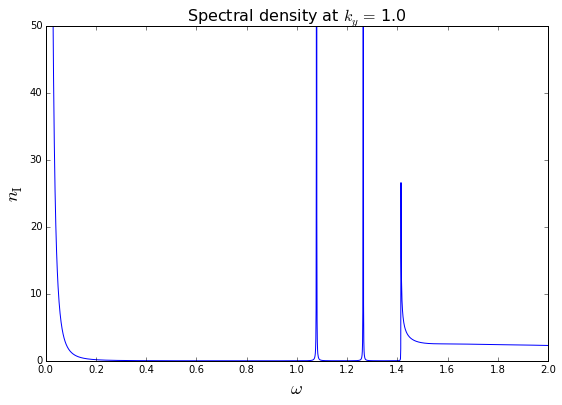

In [12]:
w_start, w_end, number_w = 0.0, 2.0, 2000 # start freqy., end freqy., number of points
eta = 0.0002  # imaginary part of squared freqy.
n_max = 50    # maximum value of spectral density along y-axis
wlist = np.linspace(w_start, w_end, number_w)
nI_tl = [wg.spectral_density(w, eta) for w in wlist]
fig = plt.figure(figsize=(9, 6))
majorLocator = MultipleLocator(0.2)  # sets major tick interval
ax = fig.add_subplot(1, 1, 1)
ax.axis([w_start, w_end, 0.0, n_max])
ax.xaxis.set_major_locator(majorLocator)
ax.set_xlabel('$\omega$', fontsize=18)
ax.set_ylabel('$n_\mathrm{I}$', fontsize=18)
ax.set_title('Spectral density at $k_y =$ %s'%(ky), fontsize=16)
ax.plot(wlist, nI_tl)

The resulting figure shows discrete peaks corresponding to localised states, with a continuum of states for $\omega>\frac{ck_y}{\sqrt\epsilon}$. The large peak at $\omega=0$, broadened by $\eta$, comes from zero-frequency longitudinal modes, absorbing the unwanted Laplace modes, and the larger the value of $N$ in the basis set, the larger this peak.  
At $k_y=1.0$ (the example shown in figure 9.3), there is a large peak at the continuum edge, which is due to an *incipient* localised state, and as $k_y$ increases this is pulled off into a third localised state.

Instead of augmenting the basis set with the longitudinal waves, we can add on *exact* solutions of Laplace's equation – two in this case, corresponding to the two interfaces ([Inglesfield](http://iopscience.iop.org/article/10.1088/0305-4470/31/42/009?pageTitle=IOPscience)):
$$\mathbf{F}^\mathrm{Laplace}_\pm(x,y)=(\pm k_y\hat{\mathbf{x}}+\mathrm{i}k_y\hat{\mathbf{y}})\exp(\pm k_y x+\mathrm{i}k_y y)$$
In the next cell we calculate the corresponding $A$ and $B$ matrices, calling `wg.matrix_setup_lexact` with arguments $M$ (transverse) and $\tilde{D}$, and then calculate and plot $n_\mathrm{I}(\omega)$. The frequency range, $\eta$, and plotting parameters are set in the previous cell.

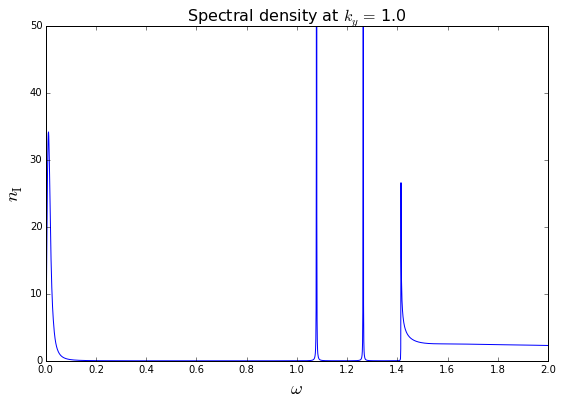

In [13]:
M = 8   # number of transverse basis functions = (2*M + 1)
wg.matrix_setup_lexact(M, D_tilde=1.5)   # D_tilde can be locally changed here
nI_lexact = [wg.spectral_density(w, eta) for w in wlist]
fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(1, 1, 1)
ax.axis([w_start, w_end, 0.0, n_max])
ax.xaxis.set_major_locator(majorLocator)
ax.set_xlabel('$\omega$', fontsize=18)
ax.set_ylabel('$n_\mathrm{I}$', fontsize=18)
ax.set_title('Spectral density at $k_y =$ %s'%(ky), fontsize=16)
ax.plot(wlist, nI_lexact)

To obtain satisfactory results with the Laplace-augmented basis, we may need a larger value of $M$ than in the the transverse + longitudinal basis set. Taking `M = 4`, `D_tilde = 1.5`, for example, a spuriuous localised state appears. This "ghost state" disappears on increasing $M$. With the Laplace-augmented basis, the peak at $\omega=0$ is much smaller than with the longitudinal-augmented basis, as it only has to accommodate two zero-frequency states.  
Unlike the longitudinal-augmented basis, the Laplace basis has not been applied to more complex systems than this simple case. 

### Working with the magnetic field###
In systems like our waveguide which are uniform in (say) the $z$-direction, electromagnetic modes with TM polarization have an electric field in the $xy$-plane, and a magnetic field in the $z$-direction $H_z(x,y)$ which satisfies a *scalar* wave equation (section 9.1.4). Working with the scalar equation we can use a smaller basis set (there are no Laplace modes to eliminate) and the matrix elements are simpler. The embedding potential in this case relates the amplitude and normal derivative of the magnetic field at the boundary between regions I and II (9.49),
$$\frac{1}{\epsilon_\mathrm{II}}\frac{\partial H_z(\mathbf{r}_S)}{\partial n_S}=\int_S \mathrm{d}\mathbf{r}_S'\Sigma^\mathrm{m}(\mathbf{r}_S,\mathbf{r}_S')H_z(\mathbf{r}_S'),$$
where $\epsilon_\mathrm{II}$ is the dielectric constant of region II (replaced by the embedding potential), and the integral is over $S$, the boundary surface between regions I and II. This is very similar to the Schrödinger equation case, and the $A$ and $B$ matrices likewise have similar structure (9.54),
$$\begin{aligned}
A_{mn}&=\frac{1}{\epsilon_\mathrm{I}}\int_\mathrm{I}\mathrm{d}\mathbf{r}\nabla F^*_m\cdot\nabla F_n -
\int_S\mathrm{d}\mathbf{r}_S\!\int_S\mathrm{d}\mathbf{r}'_S F_m^*(\mathbf{r}_S)\Sigma^\mathrm{m}(\mathbf{r}_S,\mathbf{r}_S')F_n(\mathbf{r}_S'),\\
B_{mn}&=\int_\mathrm{I}\mathrm{d}\mathbf{r}F^*_m(\mathbf{r})F_n(\mathbf{r}).
\end{aligned}$$
As basis functions we take the scalar plane waves,
$$ F_m(x,y)=\exp \mathrm{i}(g_m x + k_y y),\;\;g_m=\frac{2m\pi}{D},$$
and in the next cell we call `wg.matrix_setup_magnetic`, with arguments $M$ and $\tilde{D}$, to construct the matrices. Note that the other parameters of the calculation, in particular $\epsilon$ and $k_y$, are set up in previous cells.

In [14]:
M = 5   # number of basis functions = (2M + 1)
wg.matrix_setup_magnetic(M, D_tilde)  # D_tilde can be locally changed here

For comparison with the previous results we calculate the *electric* spectral density (rather than the magnetic spectral density), which can be written in compact form (c.f. 9.58),
$$n_\mathrm{I}(\omega)=\frac{2}{\pi\omega}\Im\mathrm{Tr}[(A-\omega^2 B)^{-1}A_1],$$
where $A_1$ has matrix elements
$$A_{1,mn}=\frac{1}{\epsilon_\mathrm{I}}\int_\mathrm{I}\mathrm{d}\mathbf{r}\nabla F^*_m\cdot\nabla F_n.$$
This is calculated and plotted in the next cell.

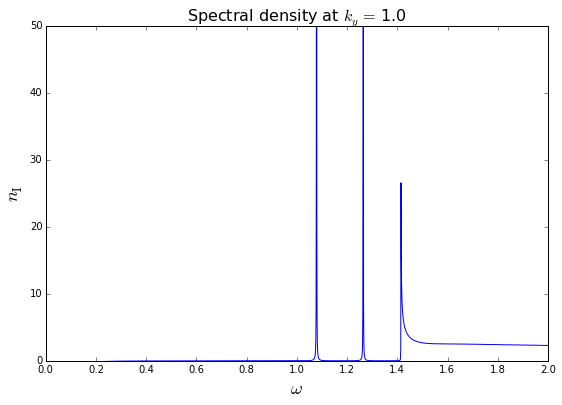

In [15]:
nI_mag_basis = [wg.spectral_density_magnetic(w, eta) for w in wlist]
fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(1, 1, 1)
ax.axis([w_start, w_end, 0.0, n_max])
ax.xaxis.set_major_locator(majorLocator)
ax.set_xlabel('$\omega$', fontsize=18)
ax.set_ylabel('$n_\mathrm{I}$', fontsize=18)
ax.set_title('Spectral density at $k_y =$ %s'%(ky), fontsize=16)
ax.plot(wlist, nI_mag_basis)

In the final cell of this section, we compare $n_\mathrm{I}(\omega)$ calculated with the magnetic basis with that calculated with the transverse + longitudinal basis.

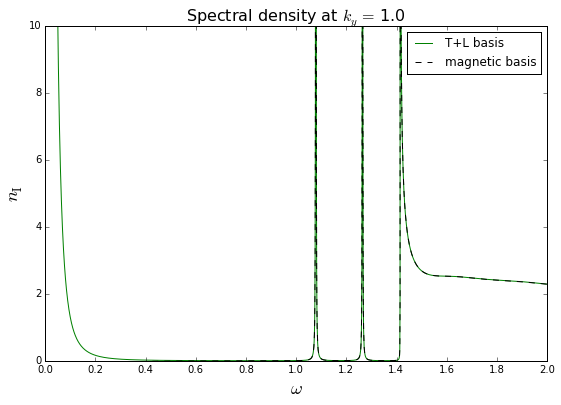

In [16]:
fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(1, 1, 1)
n_max = 10   # change n_max for finer comparison
ax.axis([w_start, w_end, 0.0, n_max]) 
ax.xaxis.set_major_locator(majorLocator)
ax.set_xlabel('$\omega$', fontsize=18)
ax.set_ylabel('$n_\mathrm{I}$', fontsize=18)
ax.set_title('Spectral density at $k_y =$ %s'%(ky), fontsize=16)
ax.plot(wlist, nI_tl, color='green', label='T+L basis')
ax.plot(wlist,nI_mag_basis, color='black', linestyle='--', label='magnetic basis')
ax.legend(fontsize=12, loc='best')

## Photonic band structure of a lattice of metallic cylinders##
As another example of electromagnetic embedding, we calculate the photonic band structure of a two-dimensional square lattice of metallic cylinders, considering the modes with an electric field in the plane perpendicular to the cylinder axes. This means that we can use the magnetic basis functions discussed in the last section, satisfying the scalar wave equation. This system is treated in [Pitarke *et al*](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.75.165415), and many of the features of the method and results are similar to the line of cylinders discussed in [Giannakis *et al*](https://www.osapublishing.org/josab/abstract.cfm?uri=josab-30-6-1755) and section 9.3 of the book.  
The metal cylinders have the Drude dielectric function,
$$\epsilon(\omega)=1- \frac{\omega_p^2}{\omega(\omega+\mathrm{i}/\tau)},$$
where $\omega_p$ is the bulk plasmon frequency and $\tau$ is the plasmon lifetime. The cylinders are replaced by an embedding potential over their surface, and the frequency-dependence of $\epsilon$ becomes part of the frequency-dependence of $\Sigma$. In region I, the vacuum region between the cylinders, the magnetic field $H_{\mathbf{k},z}(x,y)$ with Bloch wave-vector $\mathbf{k}$ is expanded in terms of two-dimensional plane waves,
$$F_{j}(x,y)=\exp\mathrm{i}[(k_x+g_{j,x})x+(k_y+g_{j,y})y],$$
where the components of the reciprocal lattice vectors are given by
$$g_{j,x}=\frac{2\pi m(j)}{a},\;\; g_{j,y}=\frac{2\pi n(j)}{a},$$
with $a$ the lattice spacing and $(m,n)$ integers. The matrix elements are simple to calculate (see [Pitarke *et al*](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.75.165415) and section 9.3.2 of the book), evaluating the matrix elements of the embedding potential by expanding the plane waves in Bessel functions over the surface of the cylinders (9.79), 
$$F_j(\mathbf{r}_S)=\sum_{m=-\infty}^\infty\mathrm{i}^m\exp\mathrm{i}m(\phi-\phi_j) J_m(k_j\rho).$$
Here $\rho$ is the radius of the cylinders, and $(k_j,\phi_j)$ represent $\mathbf{k}+\mathbf{g}_j$ in cylindrical coordinates. The summation over azimuthal quantum number $m$ is truncated to $-m_\mathrm{max}\le m\le+m_\mathrm{max}$.

The methods for this calculation are given in the `Cylinder` class in the `maxwell.py` module, and this is initiated in the following cell, with the following input: `rho_tilde` is the relative radius of the cylinders (see below); `nm`  $=m_\mathrm{max}+1$, the number of $m$ values from 0 to $m_\mathrm{max}$; `wp` $=\tilde{\omega}_p$, the reduced plasmon frequency; and `tau` $=\tilde{\tau}$, the reduced plasmon lifetime. Following [Pitarke *et al*](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.75.165415) who took a lattice of Al cylinders, $\omega_p=$ 15 eV, with lattice spacing $a\approx$ 83 Å we may use $\tilde{\omega}_p = 0.1,\;\tilde{\tau}= 1000.$ The reduced lattice constant is $\tilde{a}=2\pi$ (built in to the `Cylinder` class), and from now on we drop the tildes, *except* for `rho_tilde`, the relative radius of the cylinders given by $\tilde{\rho}=\frac{\rho}{a}.$ ( Note that despite the tilde, $\tilde{\rho}$ is not the reduced radius, which would be $\frac{2\pi\rho}{a}$.) On the second line of the cell we also input `M`, the number of plane waves in the expansion of the field.

In [17]:
rho_tilde = 0.159    # cylinder radius relative to lattice constant
nm, M = 7, 350       # number of m-values with m_max = nm - 1, number of plane waves
wp, tau = 0.1, 2000  # reduced plasmon frequency and lifetime
cyl = maxwell.Cylinder(rho_tilde, nm, wp, tau)

In the next cell we calculate the spectral density (per unit cell, integrated through region I between the cylinders) over the frequency range specified in the first line, at a Bloch wave-vector which is read in on a prompt. After reading in $\mathbf{k}=(k_x,k_y)$, the $M$ plane waves are determined, then the matrix elements are evaluated, followed by the calculation of $n_\mathrm{I}(\omega)$. This is plotted, and we are prompted for another wave-vector and the calculation is repeated and another graph presented.  
In response to the prompt, $k_x,\; k_y$ should be typed in as, for example `0.123 0.457`, or to stop the cells `s`. 

kx and ky values (type s to stop)  0.025 0


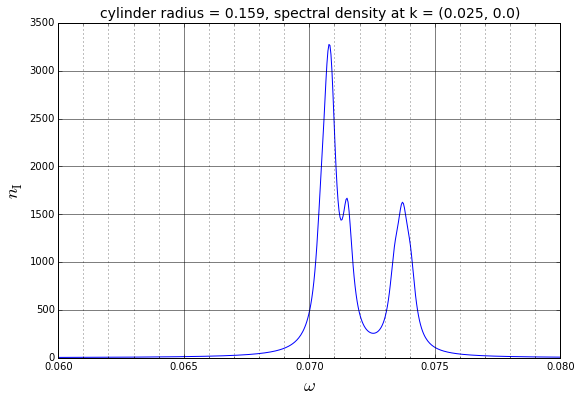

kx and ky values (type s to stop)  0.05 0


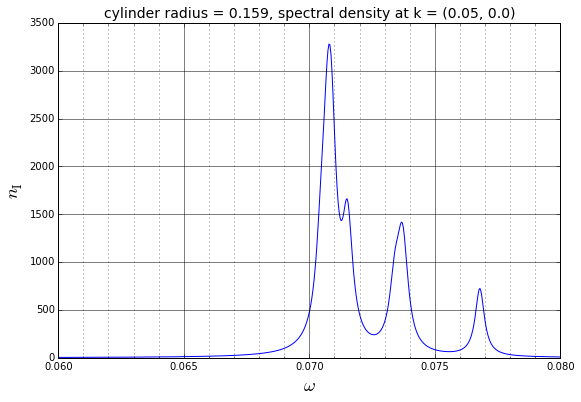

kx and ky values (type s to stop)  0.1 0


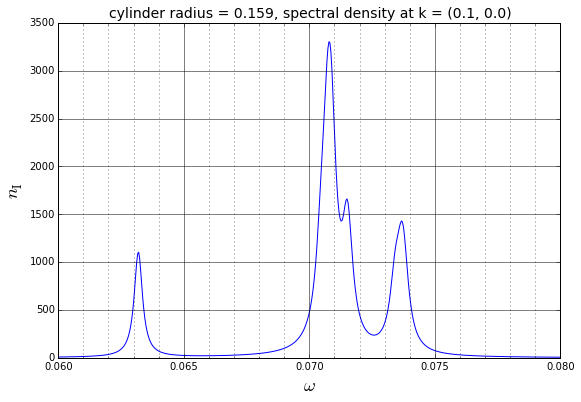

kx and ky values (type s to stop)  0.2 0


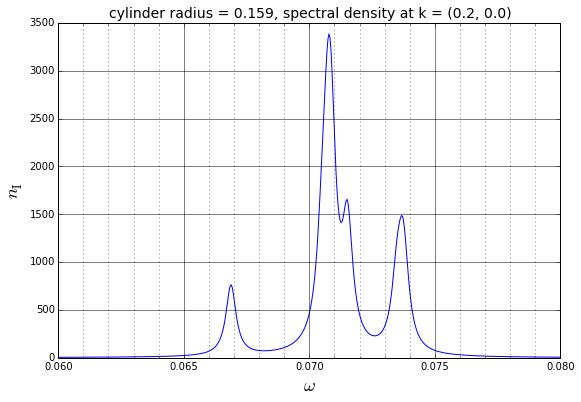

kx and ky values (type s to stop)  s


In [18]:
w_start, w_end, number_w = 0.06, 0.08, 500 # start freqy, end freqy, number of points
while True:
    k = raw_input('kx and ky values (type s to stop)  ') # example: 0.1 0.0
    k = k.split()
    if k[0] == 's':
        break
    else:
        kx = float(k[0])
        ky = float(k[1])
        cyl.recips(kx, ky, M)
        cyl.matrix()
        wlist=np.linspace(w_start, w_end, number_w)
        nI_cyl = [cyl.spectral_density(w) for w in wlist]
        fig = plt.figure(figsize=(9, 6))
        ax = fig.add_subplot(1, 1, 1)
        ax.set_xlim(w_start, w_end)
        minor_locator = AutoMinorLocator()
        ax.xaxis.set_minor_locator(minor_locator)
        ax.set_xlabel('$\omega$', fontsize=18)
        ax.set_ylabel('$n_\mathrm{I}$', fontsize=18)
        title = 'cylinder radius = %s, spectral density at k = (%s, %s)' %(rho_tilde, kx, ky)
        ax.set_title(title, fontsize=14)
        ax.plot(wlist, nI_cyl)
        ax.grid(linestyle='-')
        ax.grid(which='minor', linestyle=':')
        plt.show()

We can compare these spectral densities with the results in [Pitarke *et al*](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.75.165415), not only for $n_\mathrm{I}(\omega)$ but also the photonic band structures shown in this paper. The figure below shows the band structure as a function of $k_x$ ($k_y = 0$), for cylinders with $\omega_p=0.1$ and radius $\tilde{\rho}=0.159$.  
![Photonic band structure of lattice of cylinders](surf_plasmon.png)  
The solid lines and dots are obtained from the peaks in the spectral densities; the dotted lines are derived from an effective medium approximation, and the dashed line with gradient unity is the *light line*, corresponding to propagation in free space. The dispersionless bands correspond to surface plasmon modes, but we also see a *plasmon-polariton* where light interacts with a dipolar surface plasmon. All these features should be present in our calculations.  
One of the properties of surface plasmons on an isolated cylinder is that all the modes have the same frequency $\omega_p/\sqrt 2$, irrespective of azimuthal quantum number $m$. In the lattice, the surface plasmons interact with one another, producing the band around $\omega_p/\sqrt 2$; the effect of increasing $m_\mathrm{max}$ is to produce more and more states at $\omega=\omega_p/\sqrt 2$, increasing the size of the peak we will find at this frequency in $n_\mathrm{I}(\omega)$. This is discussed in more detail in [Giannakis *et al*](https://www.osapublishing.org/josab/abstract.cfm?uri=josab-30-6-1755) and section 9.3.3 for the related case of a line of cylinders.